# Step 3, ModelMerge: Merge the branch fall probabilites from the two models (with and without service requests) and create SQL database
** Note that throughout this and other jupyter notebooks, the following terminology is used:
- falls: refer to fallen branches (from the 311 service request dataset) since 2015
- service requests: refer to 311 service requests for damaged trees or overhanging branches (but NOT fallen branches) since 2015
- tree census: refers to the 2015 NYC Street Tree Census

Packages

In [17]:
# Import packages
%matplotlib inline
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine

### Import datasets
Import data from the model with service requests and the model without service requests and import service requests per fall by zipcode data

In [18]:
#Import model branch fall prediction data
# With service requests
SR_prob_df = pd.read_csv('Data/FinalOutputs/ServiceRequestModelOutput.csv')
# Without service requests
no_SR_prob_df = pd.read_csv('Data/FinalOutputs/NoServiceRequestModelOutput.csv')

# Import service request/fall by zipcode ratios
# This data is a shapefile and can be opened as a geodataframe
SR_fall_ratio_df = geopandas.read_file('Data/spatialdatasets/Fall_Count.shp')
# Use only the zipcode and service requests per fall data
SR_fall_ratio = SR_fall_ratio_df[['ZIPCODE','DamperFall']]

### Create normalized service request to fall ratios 
Weight fall probabilities from the models based on the normalized SR to fall ratio for the tree's zipcode

In [19]:
# Find the max service request per fall ratio for normalization use 2nd largest ratio because max is much bigger than the 2nd largest
max_SR_fall_ratio = SR_fall_ratio['DamperFall'].nlargest(n=2).iloc[1]

# Set largest ratio to the value of the 2nd largest 
SR_fall_ratio.loc[16,'DamperFall'] = max_SR_fall_ratio

In [20]:
# Create normalized service request to fall ratios to be the model merge ratios
model_merge_ratio = pd.DataFrame()
model_merge_ratio['zipcode'] = SR_fall_ratio['ZIPCODE']
model_merge_ratio['ratio'] = SR_fall_ratio['DamperFall']/max_SR_fall_ratio

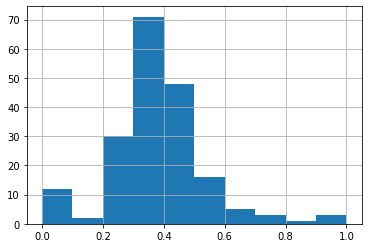

In [21]:
# check that the ratios look reasonable
model_merge_ratio['ratio'].hist()

### Merge the two models (with and without service requests)
Merge by weighting branch fall probabilities with the model merge ratios

In [22]:
# Change zipcode to an int so it can be merged with the model output data
model_merge_ratio['zipcode'] = model_merge_ratio.zipcode.astype(int)

In [23]:
# Join the model merge ratios to model outputs
SR_prob_df = SR_prob_df.merge(model_merge_ratio,how='left',right_on='zipcode',left_on='zipcode')
no_SR_prob_df = no_SR_prob_df.merge(model_merge_ratio,how='left',right_on='zipcode',left_on='zipcode')

# Then sort both dataframes on tree_id to make sure they match (the test train split may have messed up the order)
SR_prob_df.sort_values(by=['tree_id'],inplace=True)
no_SR_prob_df.sort_values(by=['tree_id'],inplace=True)

In [24]:
SR_prob_df

,tree_id,address,curb_loc,guards,health,root_grate,root_other,root_stone,sidewalk,spc_common,...,Tree Leaning/Uprooted,Hitting Building,Hitting Power/Phone Lines,Dead Branches in Tree,Blocking Street,Tree Alive - in Poor Condition,impervious_pct,heightroof,fallprob,ratio
395492,3.0,766 MANIDA STREET,1,1,2,0,0,0,1,0.015375,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.000000,0.336290,0.666667
666744,4.0,1241 LAFAYETTE AVENUE,1,1,2,0,0,0,0,0.015375,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,33.153259,0.557332,0.666667
646743,7.0,1242 SPOFFORD AVENUE,1,1,0,0,0,0,0,0.008547,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.000000,0.258500,0.666667
287089,8.0,1242 SPOFFORD AVENUE,1,1,0,0,0,0,0,0.008547,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.000000,0.258500,0.666667
553027,9.0,1242 SPOFFORD AVENUE,1,1,0,0,0,0,0,0.008547,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.000000,0.258500,0.666667
551986,10.0,1242 SPOFFORD AVENUE,1,1,2,0,0,0,0,0.023110,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.000000,0.294920,0.666667
253348,11.0,1246 SPOFFORD AVENUE,1,1,2,0,0,0,0,0.023110,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,15.950000,0.501299,0.666667
113006,12.0,1246 SPOFFORD AVENUE,1,1,2,0,0,0,0,0.023110,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,15.950000,0.501299,0.666667
187779,13.0,1246 SPOFFORD AVENUE,1,1,2,0,0,0,0,0.023110,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,15.950000,0.501299,0.666667
236106,14.0,1246 SPOFFORD AVENUE,1,1,2,0,0,0,0,0.013630,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,15.950000,0.467575,0.666667


In [25]:
# Make a merged prediction for each tree
final_fall_prob = SR_prob_df.fallprob*SR_prob_df.ratio + no_SR_prob_df.fallprob * (1-no_SR_prob_df.ratio)

### Export branch fall probability data to SQL

In [26]:
# create the final output table to send to SQL
final_table = SR_prob_df.copy()
final_table.drop(['ratio','fallprob'],axis=1,inplace=True)
final_table['fallprob'] = final_fall_prob

In [27]:
# round long decimals
final_table.heightroof=final_table.heightroof.astype(int)
final_table.fallprob = final_table.fallprob.round(decimals=2)
final_table.tree_id = final_table.tree_id.astype(int)

In [28]:
# drop any rows where fallprob is nan
final_table = final_table[pd.notnull(final_table['fallprob'])]

In [29]:
# save to csv
final_table.to_csv('Data/FinalOutputs/final_table.csv')

In [30]:
# copy data to AWS RDS postgreSQL database
# Import postgres connection info (mine has been taken out)
import PostgresAWScodes

con = None
con = psycopg2.connect(password=pwd, port=port,user=user,host=host)
cursor = con.cursor()

with open(r'Data/FinalOutputs/final_table.csv', 'r') as row:
    next(row)
    cursor.copy_from(row, 'finaltable', sep=',')
    
con.commit() 

ModuleNotFoundError: No module named 'PostgresAWScodes'

### Make outputs for maps to be in app

In [34]:
# Make dataset of trees > 0.75 fall probability for the map
high_risk_trees = final_table[final_table['fallprob']>=0.75]
high_risk_zips=high_risk_trees.groupby('zipcode').count().tree_id
high_risk_zips.to_csv('Data/FinalOutputs/high_risk_zips.csv',index=True)

C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [35]:
# join lat lon to final table to output tree maps with fall probabilities
df_imp_bldghght = pd.read_csv('Data/spatialdatasets/data_with_imp_bldghght.csv',index_col='tree_id')
df_imp_bldghght.drop(['rvalue_1', 'heightroof','address','block_id', 'created_at', 'curb_loc', 'guards', 'health',
       'problems', 'root_grate', 'root_other',''
       'root_stone', 'sidewalk', 'spc_common', 'status', 'steward', 'tree_dbh',
       'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode'],axis=1,inplace=True)
df_imp_bldghght.reset_index(inplace=True)

In [36]:
# merge final table and lat lon data
map_table = final_table.merge(df_imp_bldghght,how='inner',left_on='tree_id',right_on='tree_id')
map_table.drop_duplicates(inplace=True)

In [244]:
# export 
map_table.to_csv('Data/FinalOutputs/map_table.csv')

### Create plots for demo

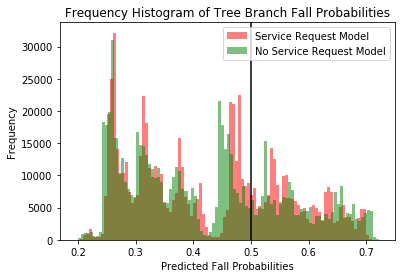

In [31]:
# Create a histogram of the distributions of all probability for different models
x1 = SR_prob_df.fallprob
x2 = no_SR_prob_df.fallprob

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='r', label='Service Request Model')
plt.hist(x2, **kwargs, color='g', label='No Service Request Model')
plt.gca().set(title='Frequency Histogram of Tree Branch Fall Probabilities', ylabel='Frequency',xlabel='Predicted Fall Probabilities')
#plt.xlim(50,75)
plt.axvline(x=.5,color='k')
plt.legend();

In [42]:
# Check counts of trees with fall prb > .5 in two models
no_SR_prob_df[no_SR_prob_df.fallprob>0.5].tree_id.count()-SR_prob_df[SR_prob_df.fallprob>0.5].tree_id.count()


-13283

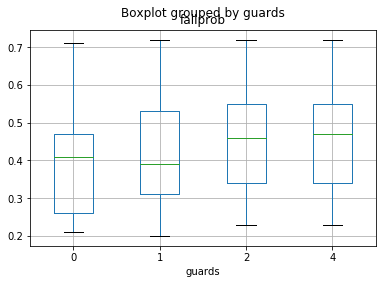

In [37]:
# Check how guards influenced predicted fall probability
map_table.boxplot(by='guards',column=['fallprob'])